In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

In [3]:
os.getcwd()

'c:\\Users\\andyk\\OneDrive\\Documents\\GitHub\\yoga-pose-classification'

In [4]:
poses = ['downdog', "goddess", "mountain", "tree", "warrior1", "warrior2"]

In [5]:
batch_size = 16
image_size = 512

In [6]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            print(filename)
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

def convert_to_jpg(path):
    for file in os.listdir(path):
        #print(path, file)
        img = Image.open(os.path.join(path, file))
        img = img.convert('RGB')
        file_name, file_ext = os.path.splitext(file)
        #print(file_name, file_ext)
        if file_ext != '.jpg':
            print(file_name)
            print(file_ext)
            img.save(os.path.join(path, f'{file_name}.jpg'))
            #os.remove(os.path.join(path, file_name))

        
    for file in os.listdir(path):
        if not file.endswith(".jpg"):
            os.remove(os.path.join(path, file))

base_path = "./dataset/poses/train/"

# for pose in poses:
#     path = os.path.join(base_path, pose)
#     removeCorruptedImages(os.path.join(base_path, pose))
#     convert_to_jpg(path)


In [7]:


train_transform = transforms.Compose(
[
    transforms.RandomResizedCrop(size=image_size, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]
    )

test_transform = transforms.Compose(
[   transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]
    )

train = torchvision.datasets.ImageFolder(root="dataset/poses/train/",
                                    transform=train_transform)
train_loader = torch.utils.data.DataLoader(train,
                                        batch_size=batch_size, shuffle=True,
                                        num_workers=4)



test = torchvision.datasets.ImageFolder(root="dataset/poses/test/",
                                    transform=test_transform)
test_loader = torch.utils.data.DataLoader(test,
                                        batch_size=batch_size, shuffle=True,
                                        num_workers=4)



In [8]:
train_data_size = len(train)
#valid_data_size = len(test)
test_data_size = len(test)

# CNN

In [ ]:
print_outputs = False

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=4, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=7, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=7, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(12)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(12)
        self.conv6 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(12*len(poses)*len(poses), len(poses))

    def forward(self, input):
        if print_outputs:
            print('FORWARD')
            print(input.shape)
        output = F.relu(self.bn1(self.conv1(input)))  
        if print_outputs:
            print(output.shape)    
        output = F.relu(self.bn2(self.conv2(output)))  
        if print_outputs:
            print(output.shape)     
        output = self.pool(output)     
        if print_outputs:
            print(output.shape)                      
        output = F.relu(self.bn4(self.conv4(output)))     
        if print_outputs:
            print(output.shape)   
        output = F.relu(self.bn5(self.conv5(output)))
        if print_outputs:
            print(output.shape)   
        output = output.view(-1, 12*len(poses)*len(poses))
        if print_outputs:
            print(output.shape)   
        output = self.fc1(output)
        if print_outputs:
            print(output.shape)   

        return output

# Instantiate a neural network model 
model = Network()

In [ ]:

 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # print("outputs shape")
            # print(outputs.shape)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i%100 == 0:
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % poses[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % poses[predicted[j]] 
                              for j in range(batch_size)))

In [ ]:
# Function to test what classes performed well
def testClasses():
    class_correct = list(0. for i in range(len(poses)))
    class_total = list(0. for i in range(len(poses)))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(poses)):
        print('Accuracy of %5s : %2d %%' % (
            poses[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
testBatch()

In [ ]:
testClasses()

In [ ]:
# Let's build our model
train(5)
print('Finished Training')

# # Test which classes performed well
# testModelAccuracy()

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))

# Test with batch of images
testBatch()

# Transfer Learning

In [9]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\andyk\OneDrive\Documents\GitHub\yoga-pose-classification\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andyk\OneDrive\Documents\GitHub\yoga-pose-classification\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Freeze model parameters
for param in resnet18.parameters():
    param.requires_grad = False

In [11]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(poses)), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [12]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = Adam(resnet18.parameters())

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)
#device = "cuda:0"

In [14]:
torch.cuda.is_available()

False

In [16]:
epochs = 10
import time

start = time.time()
history = []
best_loss = 100000.0
best_epoch = None

for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        resnet18.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = resnet18(inputs)
            # Compute loss
            loss = loss_func(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Validation - No gradient tracking needed
with torch.no_grad():
    # Set to evaluation mode
    resnet18.eval()
    # Validation loop
    for j, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass - compute outputs on input data using the model
        outputs = resnet18(inputs)
        # Compute loss
        loss = loss_func(outputs, labels)
        # Compute the total loss for the batch and add it to valid_loss
        test_loss += loss.item() * inputs.size(0)
        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        # Compute total accuracy in the whole batch and add to valid_acc
        test_acc += acc.item() * inputs.size(0)
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
# Find average training loss and training accuracy
avg_train_loss = train_loss/train_data_size 
avg_train_acc = train_acc/float(train_data_size)
# Find average training loss and training accuracy
avg_valid_loss = test_loss/test_data_size 
avg_valid_acc = test_acc/float(test_data_size)
history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
epoch_end = time.time()
print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, nttValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

Epoch: 1/10
Batch number: 000, Training: Loss: 1.6277, Accuracy: 0.4375
Batch number: 001, Training: Loss: 1.7234, Accuracy: 0.3125
Batch number: 002, Training: Loss: 1.7017, Accuracy: 0.3125
Batch number: 003, Training: Loss: 1.8370, Accuracy: 0.1250
Batch number: 004, Training: Loss: 1.8073, Accuracy: 0.3125
Batch number: 005, Training: Loss: 1.6252, Accuracy: 0.2500
Batch number: 006, Training: Loss: 1.6676, Accuracy: 0.2500
Batch number: 007, Training: Loss: 1.7731, Accuracy: 0.1250
Batch number: 008, Training: Loss: 1.5799, Accuracy: 0.3125
Batch number: 009, Training: Loss: 1.6770, Accuracy: 0.2500
Batch number: 010, Training: Loss: 1.7865, Accuracy: 0.2500
Batch number: 011, Training: Loss: 1.6375, Accuracy: 0.3125
Batch number: 012, Training: Loss: 1.8075, Accuracy: 0.3125
Batch number: 013, Training: Loss: 1.7647, Accuracy: 0.2500
Batch number: 014, Training: Loss: 1.5530, Accuracy: 0.5000
Batch number: 015, Training: Loss: 1.7876, Accuracy: 0.1875
Batch number: 016, Training:

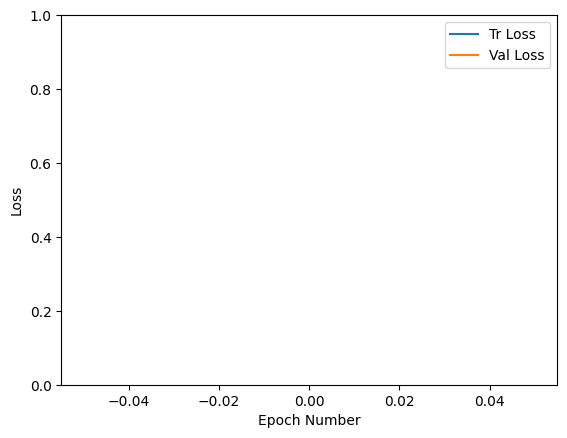

In [17]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()

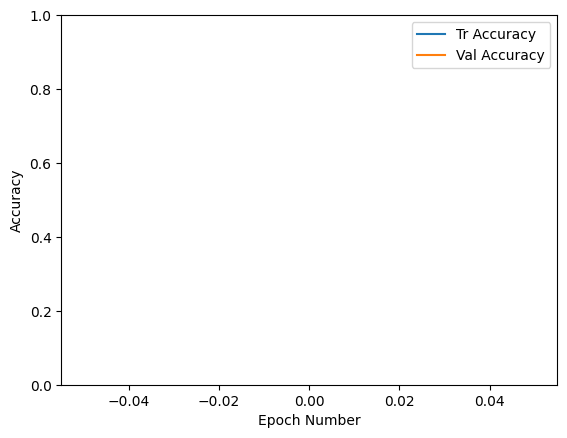

In [18]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
#plt.savefig(+'_accuracy_curve.png')
plt.show()